# CMPUT 655 - Assignment 5
## Lucas Cruz

Kept it simple this time, hope it helps to mark it.

The plots and discussions were included in the PDF submitted.

## Part I

100%|██████████| 50/50 [01:15<00:00,  1.50s/it]


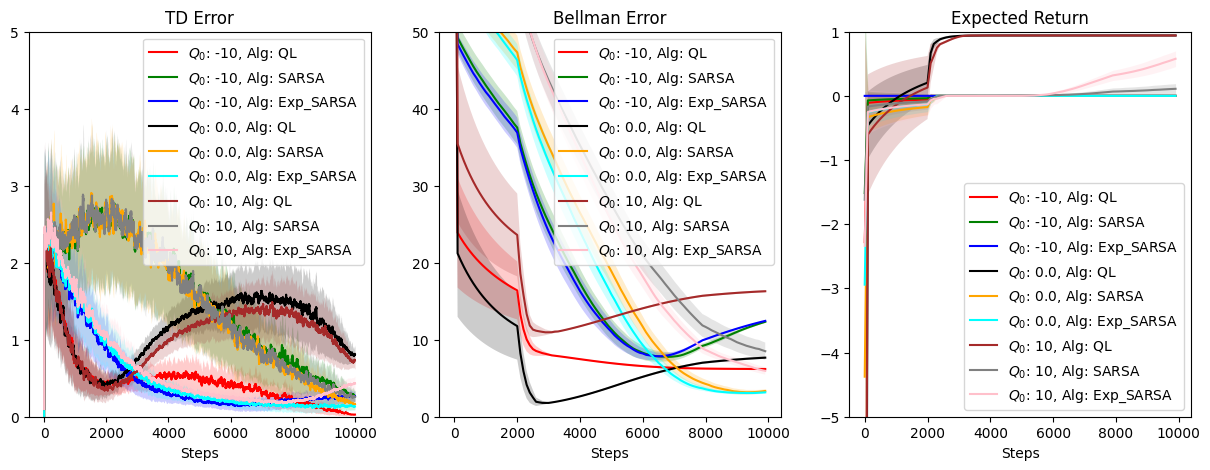

In [37]:
import gymnasium
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

np.set_printoptions(precision=3)

env = gymnasium.make("Gym-Gridworlds/Penalty-3x3-v0")
n_states = env.observation_space.n
n_actions = env.action_space.n

R = np.zeros((n_states, n_actions))
P = np.zeros((n_states, n_actions, n_states))
T = np.zeros((n_states, n_actions))

env.reset()
for s in range(n_states):
    for a in range(n_actions):
        env.unwrapped.set_state(s)
        s_next, r, terminated, _, _ = env.step(a)
        R[s, a] = r
        P[s, a, s_next] = 1.0
        T[s, a] = terminated

P = P * (1.0 - T[..., None])  # next state probability for terminal transitions is 0

def bellman_q(pi, gamma, max_iter=1000):
    delta = np.inf
    iter = 0
    Q = np.zeros((n_states, n_actions))
    be = np.zeros((max_iter))
    while delta > 1e-5 and iter < max_iter:
        Q_new = R + (np.dot(P, gamma * (Q * pi)).sum(-1))
        delta = np.abs(Q_new - Q).sum()
        be[iter] = delta
        Q = Q_new
        iter += 1
    return Q

def eps_greedy_action(Q, s, eps):
    if np.random.rand() < eps:
        return np.random.choice(n_actions)  # Explore
    else:
        max_value = Q[s].max()
        ties = [i for i, v in enumerate(Q[s]) if v == max_value]
        return np.random.choice(ties) # Exploit - random tie

def expected_return(env, Q, gamma, episodes=10):
    G = np.zeros(episodes)
    for e in range(episodes):
        s, _ = env.reset(seed=e)
        done = False
        t = 0
        while not done:
            a = eps_greedy_action(Q, s, 0.0)
            s_next, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            G[e] += gamma**t * r
            s = s_next
            t += 1
    return G.mean()

def compute_epsilon_greedy_pi(Q, eps):
    n_states, n_actions = Q.shape
    pi = np.ones((n_states, n_actions)) * (eps / n_actions)
    for s in range(n_states):
        q_values = Q[s]
        max_q_value = q_values.max()
        max_actions = np.argwhere(q_values == max_q_value).flatten()
        pi[s, max_actions] += (1.0 - eps) / len(max_actions)
    return pi

def td(env, env_eval, Q, gamma, eps, alpha, max_steps, alg):
    be = []
    exp_ret = []
    tde = np.zeros(max_steps)
    eps_decay = eps / max_steps
    alpha_decay = alpha / max_steps
    tot_steps = 0

    while tot_steps < max_steps:
        s_t, info = env.reset()
        done = False

        if alg == "QL":
            # play one episode
            while not done and tot_steps < max_steps:
                a_t = eps_greedy_action(Q, s_t, eps)
                s_prime, reward, terminated, truncated, info = env.step(a_t)
                if tot_steps >= max_steps - 1:  # if we reach the total steps, truncate it
                    truncated = True

                # Compute the future Q value
                future_q_value = Q[s_prime].max()
                temporal_difference = reward + gamma * future_q_value - Q[s_t][a_t]

                # Update Q-values
                Q[s_t][a_t] += alpha * temporal_difference
                tde[tot_steps] = np.abs(temporal_difference)

                done = terminated or truncated
                s_t = s_prime
                tot_steps += 1
                eps = max(eps - eps_decay, 0.01)
                alpha = max(alpha - alpha_decay, 0.001)

                if tot_steps % 100 == 0:
                    a_greedy = [eps_greedy_action(Q, s_i, eps=0) for s_i in range(n_states)]
                    pi_greedy = np.eye(n_actions)[a_greedy]
                    be.append(np.mean(np.abs(bellman_q(pi_greedy, gamma) - Q)))
                    exp_ret.append(expected_return(env_eval, Q, gamma, episodes=10))

        elif alg == "SARSA":
            a_t = eps_greedy_action(Q, s_t, eps)

            # play one episode
            while not done and tot_steps < max_steps:
                s_prime, reward, terminated, truncated, info = env.step(a_t)
                if tot_steps >= max_steps - 1:
                    truncated = True

                a_prime = eps_greedy_action(Q, s_prime, eps)
                future_q_value = Q[s_prime, a_prime]
                temporal_difference = reward + gamma * future_q_value - Q[s_t][a_t]

                Q[s_t][a_t] += alpha * temporal_difference
                tde[tot_steps] = np.abs(temporal_difference)

                done = terminated or truncated
                s_t = s_prime
                a_t = a_prime
                tot_steps += 1
                eps = max(eps - eps_decay, 0.01)
                alpha = max(alpha - alpha_decay, 0.001)

                if tot_steps % 100 == 0:
                    pi = compute_epsilon_greedy_pi(Q, eps)
                    be.append(np.mean(np.abs(bellman_q(pi, gamma) - Q)))
                    exp_ret.append(expected_return(env_eval, Q, gamma, episodes=10))

        else:  # Expected SARSA
            a_t = eps_greedy_action(Q, s_t, eps)

            # play one episode
            while not done and tot_steps < max_steps:
                s_prime, reward, terminated, truncated, info = env.step(a_t)
                if tot_steps >= max_steps - 1:
                    truncated = True

                q_values = Q[s_prime]
                max_q_value = q_values.max()
                max_actions = np.argwhere(q_values == max_q_value).flatten()

                pi = np.ones(n_actions) * (eps / n_actions)
                pi[max_actions] += (1.0 - eps) / len(max_actions)
                expected_q_value = np.dot(pi, q_values)

                temporal_difference = reward + gamma * expected_q_value - Q[s_t][a_t]

                Q[s_t][a_t] += alpha * temporal_difference
                tde[tot_steps] = np.abs(temporal_difference)

                done = terminated or truncated
                s_t = s_prime
                a_t = eps_greedy_action(Q, s_t, eps) 
                tot_steps += 1
                eps = max(eps - eps_decay, 0.01)
                alpha = max(alpha - alpha_decay, 0.001)

                if tot_steps % 100 == 0:
                    pi = compute_epsilon_greedy_pi(Q, eps)
                    be.append(np.mean(np.abs(bellman_q(pi, gamma) - Q)))
                    exp_ret.append(expected_return(env_eval, Q, gamma, episodes=10))
    return Q, be, tde, exp_ret

# https://stackoverflow.com/a/63458548/754136
def smooth(arr, span):
    re = np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")
    re[0] = arr[0]
    for i in range(1, span + 1):
        re[i] = np.average(arr[: i + span])
        re[-i] = np.average(arr[-i - span :])
    return re

def error_shade_plot(ax, data, stepsize, smoothing_window=1, **kwargs):
    y = np.nanmean(data, 0)
    x = np.arange(len(y))
    x = [stepsize * step for step in range(len(y))]
    if smoothing_window > 1:
        y = smooth(y, smoothing_window)
    (line,) = ax.plot(x, y, **kwargs)
    error = np.nanstd(data, axis=0)
    if smoothing_window > 1:
        error = smooth(error, smoothing_window)
    error = 1.96 * error / np.sqrt(data.shape[0])
    ax.fill_between(x, y - error, y + error, alpha=0.2, linewidth=0.0, color=line.get_color())

gamma = 0.99
alpha = 0.1
eps = 1.0
max_steps = 10000
horizon = 10

init_values = [-10, 0.0, 10]
algs = ["QL", "SARSA", "Exp_SARSA"]
seeds = np.arange(50) 

results_be = np.zeros((
    len(init_values),
    len(algs),
    len(seeds),
    max_steps // 100,
))
results_tde = np.zeros((
    len(init_values),
    len(algs),
    len(seeds),
    max_steps,
))
results_exp_ret = np.zeros((
    len(init_values),
    len(algs),
    len(seeds),
    max_steps // 100,
))

fig, axs = plt.subplots(1, 3, figsize=(15,5))

for ax in axs:
    ax.set_prop_cycle(
        color=["red", "green", "blue", "black", "orange", "cyan", "brown", "gray", "pink"]
    )
    ax.set_xlabel("Steps")

env = gymnasium.make(
    "Gym-Gridworlds/Penalty-3x3-v0",
    max_episode_steps=horizon,
    reward_noise_std=0.0,
)

env_eval = gymnasium.make(
    "Gym-Gridworlds/Penalty-3x3-v0",
    max_episode_steps=horizon,
)

for i, init_value in enumerate(init_values):
    for j, alg in enumerate(algs):
        for k, seed in enumerate(tqdm(seeds)):
            np.random.seed(seed)
            Q = np.zeros((n_states, n_actions)) + init_value
            Q, be, tde, exp_ret = td(env, env_eval, Q, gamma, eps, alpha, max_steps, alg)
            results_be[i, j, k] = be
            results_tde[i, j, k] = tde
            results_exp_ret[i, j, k] = exp_ret
        label = f"$Q_0$: {init_value}, Alg: {alg}"
        axs[0].set_title("TD Error")
        error_shade_plot(
            axs[0],
            results_tde[i, j],
            stepsize=1,
            smoothing_window=20,
            label=label,
        )
        axs[0].legend()
        axs[0].set_ylim([0, 5])
        axs[1].set_title("Bellman Error")
        error_shade_plot(
            axs[1],
            results_be[i, j],
            stepsize=100,
            smoothing_window=20,
            label=label,
        )
        axs[1].legend()
        axs[1].set_ylim([0, 50])
        axs[2].set_title("Expected Return")
        error_shade_plot(
            axs[2],
            results_exp_ret[i, j],
            stepsize=100,
            smoothing_window=20,
            label=label,
        )
        axs[2].legend()
        axs[2].set_ylim([-5, 1])

plt.show()


## Part II

100%|██████████| 50/50 [01:28<00:00,  1.78s/it]


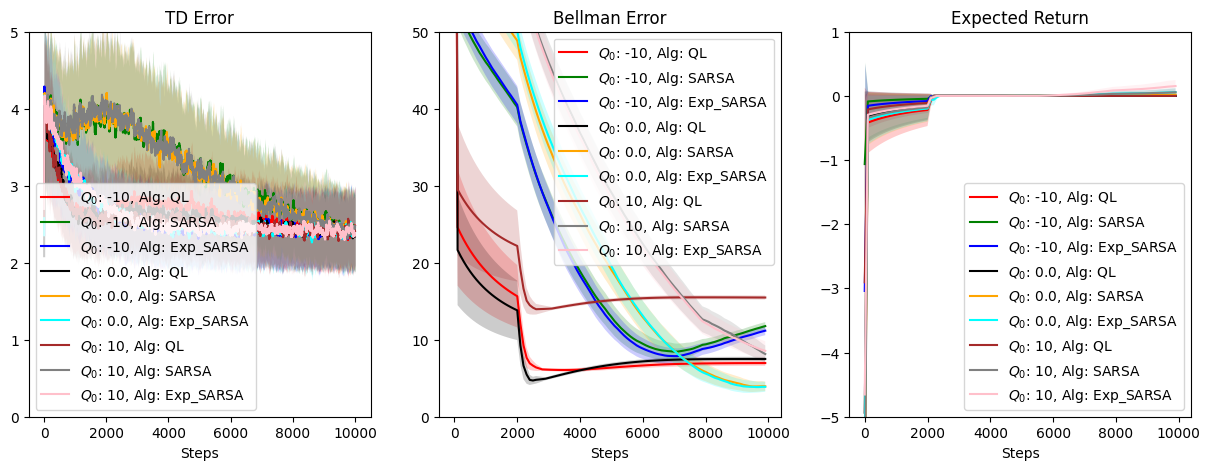

In [38]:
import gymnasium
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

np.set_printoptions(precision=3)

env = gymnasium.make("Gym-Gridworlds/Penalty-3x3-v0")
n_states = env.observation_space.n
n_actions = env.action_space.n

R = np.zeros((n_states, n_actions))
P = np.zeros((n_states, n_actions, n_states))
T = np.zeros((n_states, n_actions))

env.reset()
for s in range(n_states):
    for a in range(n_actions):
        env.unwrapped.set_state(s)
        s_next, r, terminated, _, _ = env.step(a)
        R[s, a] = r
        P[s, a, s_next] = 1.0
        T[s, a] = terminated

P = P * (1.0 - T[..., None])  # next state probability for terminal transitions is 0

def bellman_q(pi, gamma, max_iter=1000):
    delta = np.inf
    iter = 0
    Q = np.zeros((n_states, n_actions))
    be = np.zeros((max_iter))
    while delta > 1e-5 and iter < max_iter:
        Q_new = R + (np.dot(P, gamma * (Q * pi)).sum(-1))
        delta = np.abs(Q_new - Q).sum()
        be[iter] = delta
        Q = Q_new
        iter += 1
    return Q

def eps_greedy_action(Q, s, eps):
    if np.random.rand() < eps:
        return np.random.choice(n_actions)  # Explore
    else:
        max_value = Q[s].max()
        ties = [i for i, v in enumerate(Q[s]) if v == max_value]
        return np.random.choice(ties) # Exploit - random tie

def expected_return(env, Q, gamma, episodes=10):
    G = np.zeros(episodes)
    for e in range(episodes):
        s, _ = env.reset(seed=e)
        done = False
        t = 0
        while not done:
            a = eps_greedy_action(Q, s, 0.0)
            s_next, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            G[e] += gamma**t * r
            s = s_next
            t += 1
    return G.mean()

def compute_epsilon_greedy_pi(Q, eps):
    n_states, n_actions = Q.shape
    pi = np.ones((n_states, n_actions)) * (eps / n_actions)
    for s in range(n_states):
        q_values = Q[s]
        max_q_value = q_values.max()
        max_actions = np.argwhere(q_values == max_q_value).flatten()
        pi[s, max_actions] += (1.0 - eps) / len(max_actions)
    return pi

def td(env, env_eval, Q, gamma, eps, alpha, max_steps, alg):
    be = []
    exp_ret = []
    tde = np.zeros(max_steps)
    eps_decay = eps / max_steps
    alpha_decay = alpha / max_steps
    tot_steps = 0

    while tot_steps < max_steps:
        s_t, info = env.reset()
        done = False

        if alg == "QL":
            # play one episode
            while not done and tot_steps < max_steps:
                a_t = eps_greedy_action(Q, s_t, eps)
                s_prime, reward, terminated, truncated, info = env.step(a_t)
                if tot_steps >= max_steps - 1:  # if we reach the total steps, truncate it
                    truncated = True

                # Compute the future Q value
                future_q_value = Q[s_prime].max()
                temporal_difference = reward + gamma * future_q_value - Q[s_t][a_t]

                # Update Q-values
                Q[s_t][a_t] += alpha * temporal_difference
                tde[tot_steps] = np.abs(temporal_difference)

                done = terminated or truncated
                s_t = s_prime
                tot_steps += 1
                eps = max(eps - eps_decay, 0.01)
                alpha = max(alpha - alpha_decay, 0.001)

                if tot_steps % 100 == 0:
                    a_greedy = [eps_greedy_action(Q, s_i, eps=0) for s_i in range(n_states)]
                    pi_greedy = np.eye(n_actions)[a_greedy]
                    be.append(np.mean(np.abs(bellman_q(pi_greedy, gamma) - Q)))
                    exp_ret.append(expected_return(env_eval, Q, gamma, episodes=10))

        elif alg == "SARSA":
            a_t = eps_greedy_action(Q, s_t, eps)

            # play one episode
            while not done and tot_steps < max_steps:
                s_prime, reward, terminated, truncated, info = env.step(a_t)
                if tot_steps >= max_steps - 1:
                    truncated = True

                a_prime = eps_greedy_action(Q, s_prime, eps)
                future_q_value = Q[s_prime, a_prime]
                temporal_difference = reward + gamma * future_q_value - Q[s_t][a_t]

                Q[s_t][a_t] += alpha * temporal_difference
                tde[tot_steps] = np.abs(temporal_difference)

                done = terminated or truncated
                s_t = s_prime
                a_t = a_prime
                tot_steps += 1
                eps = max(eps - eps_decay, 0.01)
                alpha = max(alpha - alpha_decay, 0.001)

                if tot_steps % 100 == 0:
                    pi = compute_epsilon_greedy_pi(Q, eps)
                    be.append(np.mean(np.abs(bellman_q(pi, gamma) - Q)))
                    exp_ret.append(expected_return(env_eval, Q, gamma, episodes=10))

        else:  # Expected SARSA
            a_t = eps_greedy_action(Q, s_t, eps)

            # play one episode
            while not done and tot_steps < max_steps:
                s_prime, reward, terminated, truncated, info = env.step(a_t)
                if tot_steps >= max_steps - 1:
                    truncated = True

                q_values = Q[s_prime]
                max_q_value = q_values.max()
                max_actions = np.argwhere(q_values == max_q_value).flatten()

                pi = np.ones(n_actions) * (eps / n_actions)
                pi[max_actions] += (1.0 - eps) / len(max_actions)
                expected_q_value = np.dot(pi, q_values)

                temporal_difference = reward + gamma * expected_q_value - Q[s_t][a_t]

                Q[s_t][a_t] += alpha * temporal_difference
                tde[tot_steps] = np.abs(temporal_difference)

                done = terminated or truncated
                s_t = s_prime
                a_t = eps_greedy_action(Q, s_t, eps) 
                tot_steps += 1
                eps = max(eps - eps_decay, 0.01)
                alpha = max(alpha - alpha_decay, 0.001)

                if tot_steps % 100 == 0:
                    pi = compute_epsilon_greedy_pi(Q, eps)
                    be.append(np.mean(np.abs(bellman_q(pi, gamma) - Q)))
                    exp_ret.append(expected_return(env_eval, Q, gamma, episodes=10))
    return Q, be, tde, exp_ret

# https://stackoverflow.com/a/63458548/754136
def smooth(arr, span):
    re = np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")
    re[0] = arr[0]
    for i in range(1, span + 1):
        re[i] = np.average(arr[: i + span])
        re[-i] = np.average(arr[-i - span :])
    return re

def error_shade_plot(ax, data, stepsize, smoothing_window=1, **kwargs):
    y = np.nanmean(data, 0)
    x = np.arange(len(y))
    x = [stepsize * step for step in range(len(y))]
    if smoothing_window > 1:
        y = smooth(y, smoothing_window)
    (line,) = ax.plot(x, y, **kwargs)
    error = np.nanstd(data, axis=0)
    if smoothing_window > 1:
        error = smooth(error, smoothing_window)
    error = 1.96 * error / np.sqrt(data.shape[0])
    ax.fill_between(x, y - error, y + error, alpha=0.2, linewidth=0.0, color=line.get_color())

gamma = 0.99
alpha = 0.1
eps = 1.0
max_steps = 10000
horizon = 10

init_values = [-10, 0.0, 10]
algs = ["QL", "SARSA", "Exp_SARSA"]
seeds = np.arange(50) 

results_be = np.zeros((
    len(init_values),
    len(algs),
    len(seeds),
    max_steps // 100,
))
results_tde = np.zeros((
    len(init_values),
    len(algs),
    len(seeds),
    max_steps,
))
results_exp_ret = np.zeros((
    len(init_values),
    len(algs),
    len(seeds),
    max_steps // 100,
))

fig, axs = plt.subplots(1, 3, figsize=(15,5))

for ax in axs:
    ax.set_prop_cycle(
        color=["red", "green", "blue", "black", "orange", "cyan", "brown", "gray", "pink"]
    )
    ax.set_xlabel("Steps")

env = gymnasium.make(
    "Gym-Gridworlds/Penalty-3x3-v0",
    max_episode_steps=horizon,
    reward_noise_std=3.0,
)

env_eval = gymnasium.make(
    "Gym-Gridworlds/Penalty-3x3-v0",
    max_episode_steps=horizon,
)

for i, init_value in enumerate(init_values):
    for j, alg in enumerate(algs):
        for k, seed in enumerate(tqdm(seeds)):
            np.random.seed(seed)
            Q = np.zeros((n_states, n_actions)) + init_value
            Q, be, tde, exp_ret = td(env, env_eval, Q, gamma, eps, alpha, max_steps, alg)
            results_be[i, j, k] = be
            results_tde[i, j, k] = tde
            results_exp_ret[i, j, k] = exp_ret
        label = f"$Q_0$: {init_value}, Alg: {alg}"
        axs[0].set_title("TD Error")
        error_shade_plot(
            axs[0],
            results_tde[i, j],
            stepsize=1,
            smoothing_window=20,
            label=label,
        )
        axs[0].legend()
        axs[0].set_ylim([0, 5])
        axs[1].set_title("Bellman Error")
        error_shade_plot(
            axs[1],
            results_be[i, j],
            stepsize=100,
            smoothing_window=20,
            label=label,
        )
        axs[1].legend()
        axs[1].set_ylim([0, 50])
        axs[2].set_title("Expected Return")
        error_shade_plot(
            axs[2],
            results_exp_ret[i, j],
            stepsize=100,
            smoothing_window=20,
            label=label,
        )
        axs[2].legend()
        axs[2].set_ylim([-5, 1])

plt.show()


## Part III

100%|██████████| 50/50 [01:04<00:00,  1.28s/it]


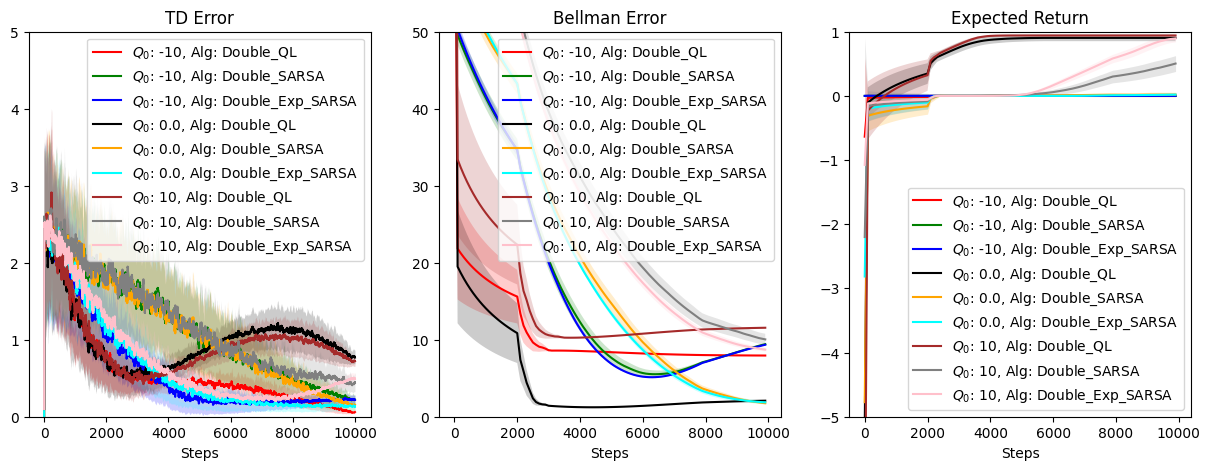

In [40]:
import gymnasium
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

np.set_printoptions(precision=3)

env = gymnasium.make("Gym-Gridworlds/Penalty-3x3-v0")
n_states = env.observation_space.n
n_actions = env.action_space.n

R = np.zeros((n_states, n_actions))
P = np.zeros((n_states, n_actions, n_states))
T = np.zeros((n_states, n_actions))

env.reset()
for s in range(n_states):
    for a in range(n_actions):
        env.unwrapped.set_state(s)
        s_next, r, terminated, _, _ = env.step(a)
        R[s, a] = r
        P[s, a, s_next] = 1.0
        T[s, a] = terminated

P = P * (1.0 - T[..., None])  # next state probability for terminal transitions is 0

def bellman_q(pi, gamma, max_iter=1000):
    delta = np.inf
    iter = 0
    Q = np.zeros((n_states, n_actions))
    be = np.zeros((max_iter))
    while delta > 1e-5 and iter < max_iter:
        Q_new = R + (np.dot(P, gamma * (Q * pi)).sum(-1))
        delta = np.abs(Q_new - Q).sum()
        be[iter] = delta
        Q = Q_new
        iter += 1
    return Q

def eps_greedy_action(Q, s, eps):
    if np.random.rand() < eps:
        return np.random.choice(n_actions)  # Explore
    else:
        max_value = Q[s].max()
        ties = [i for i, v in enumerate(Q[s]) if v == max_value]
        return np.random.choice(ties)  # Exploit - random tie

def expected_return(env, Q, gamma, episodes=10):
    G = np.zeros(episodes)
    for e in range(episodes):
        s, _ = env.reset(seed=e)
        done = False
        t = 0
        while not done:
            a = eps_greedy_action(Q, s, 0.0)
            s_next, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            G[e] += gamma ** t * r
            s = s_next
            t += 1
    return G.mean()

def compute_epsilon_greedy_pi(Q, eps):
    n_states, n_actions = Q.shape
    pi = np.ones((n_states, n_actions)) * (eps / n_actions)
    for s in range(n_states):
        q_values = Q[s]
        max_q_value = q_values.max()
        max_actions = np.argwhere(q_values == max_q_value).flatten()
        pi[s, max_actions] += (1.0 - eps) / len(max_actions)
    return pi

def td_double_qlearning(env, env_eval, Q1, Q2, gamma, eps, alpha, max_steps):
    be = []
    exp_ret = []
    tde = np.zeros(max_steps)
    eps_decay = eps / max_steps
    alpha_decay = alpha / max_steps
    tot_steps = 0

    while tot_steps < max_steps:
        s_t, info = env.reset()
        done = False

        while not done and tot_steps < max_steps:
            a_t = eps_greedy_action(Q1 + Q2, s_t, eps)
            s_prime, reward, terminated, truncated, info = env.step(a_t)
            if tot_steps >= max_steps - 1:
                truncated = True

            # Randomly choose which Q to update
            if np.random.rand() < 0.5:
                # Update Q1
                a_prime = np.argmax(Q1[s_prime])
                td_target = reward + gamma * Q2[s_prime][a_prime]
                temporal_difference = td_target - Q1[s_t][a_t]
                Q1[s_t][a_t] += alpha * temporal_difference
            else:
                # Update Q2
                a_prime = np.argmax(Q2[s_prime])
                td_target = reward + gamma * Q1[s_prime][a_prime]
                temporal_difference = td_target - Q2[s_t][a_t]
                Q2[s_t][a_t] += alpha * temporal_difference

            tde[tot_steps] = np.abs(temporal_difference)

            done = terminated or truncated
            s_t = s_prime
            tot_steps += 1
            eps = max(eps - eps_decay, 0.01)
            alpha = max(alpha - alpha_decay, 0.001)

            if tot_steps % 100 == 0:
                Q_sum = Q1 + Q2
                a_greedy = [eps_greedy_action(Q_sum, s_i, eps=0) for s_i in range(n_states)]
                pi_greedy = np.eye(n_actions)[a_greedy]
                be.append(np.mean(np.abs(bellman_q(pi_greedy, gamma) - Q_sum / 2)))
                exp_ret.append(expected_return(env_eval, Q_sum / 2, gamma, episodes=10))

    return Q1 + Q2, be, tde, exp_ret

def td_double_sarsa(env, env_eval, Q1, Q2, gamma, eps, alpha, max_steps):
    be = []
    exp_ret = []
    tde = np.zeros(max_steps)
    eps_decay = eps / max_steps
    alpha_decay = alpha / max_steps
    tot_steps = 0

    while tot_steps < max_steps:
        s_t, info = env.reset()
        done = False

        # https://www.scirp.org/journal/paperinformation?paperid=71237
        # Choose action using the sum of Q1 and Q2
        a_t = eps_greedy_action(Q1 + Q2, s_t, eps)

        while not done and tot_steps < max_steps:
            s_prime, reward, terminated, truncated, info = env.step(a_t)
            if tot_steps >= max_steps - 1:
                truncated = True

            a_prime = eps_greedy_action(Q1 + Q2, s_prime, eps)

            # Randomly choose which Q to update
            if np.random.rand() < 0.5:
                td_target = reward + gamma * Q2[s_prime][a_prime]
                temporal_difference = td_target - Q1[s_t][a_t]
                Q1[s_t][a_t] += alpha * temporal_difference
            else:
                td_target = reward + gamma * Q1[s_prime][a_prime]
                temporal_difference = td_target - Q2[s_t][a_t]
                Q2[s_t][a_t] += alpha * temporal_difference

            tde[tot_steps] = np.abs(temporal_difference)

            done = terminated or truncated
            s_t = s_prime
            a_t = a_prime
            tot_steps += 1
            eps = max(eps - eps_decay, 0.01)
            alpha = max(alpha - alpha_decay, 0.001)

            if tot_steps % 100 == 0:
                Q_sum = Q1 + Q2
                pi = compute_epsilon_greedy_pi(Q_sum, eps)
                be.append(np.mean(np.abs(bellman_q(pi, gamma) - Q_sum / 2)))
                exp_ret.append(expected_return(env_eval, Q_sum / 2, gamma, episodes=10))

    return Q1 + Q2, be, tde, exp_ret

def td_double_expected_sarsa(env, env_eval, Q1, Q2, gamma, eps, alpha, max_steps):
    be = []
    exp_ret = []
    tde = np.zeros(max_steps)
    eps_decay = eps / max_steps
    alpha_decay = alpha / max_steps
    tot_steps = 0

    while tot_steps < max_steps:
        s_t, info = env.reset()
        done = False

        # https://www.scirp.org/journal/paperinformation?paperid=71237
        a_t = eps_greedy_action(Q1 + Q2, s_t, eps)

        while not done and tot_steps < max_steps:
            s_prime, reward, terminated, truncated, info = env.step(a_t)
            if tot_steps >= max_steps - 1:
                truncated = True

            # Compute expected Q using both Q1 and Q2
            Q_sum = Q1 + Q2
            q_values = Q_sum[s_prime]
            max_q_value = q_values.max()
            max_actions = np.argwhere(q_values == max_q_value).flatten()

            pi = np.ones(n_actions) * (eps / n_actions)
            pi[max_actions] += (1.0 - eps) / len(max_actions)
            expected_q_value = np.dot(pi, Q2[s_prime])

            # Randomly choose which Q to update
            if np.random.rand() < 0.5:
                td_target = reward + gamma * expected_q_value
                temporal_difference = td_target - Q1[s_t][a_t]
                Q1[s_t][a_t] += alpha * temporal_difference
            else:
                expected_q_value = np.dot(pi, Q1[s_prime])
                td_target = reward + gamma * expected_q_value
                temporal_difference = td_target - Q2[s_t][a_t]
                Q2[s_t][a_t] += alpha * temporal_difference

            tde[tot_steps] = np.abs(temporal_difference)

            done = terminated or truncated
            s_t = s_prime
            a_t = eps_greedy_action(Q1 + Q2, s_t, eps)
            tot_steps += 1
            eps = max(eps - eps_decay, 0.01)
            alpha = max(alpha - alpha_decay, 0.001)

            if tot_steps % 100 == 0:
                Q_sum = Q1 + Q2
                pi = compute_epsilon_greedy_pi(Q_sum, eps)
                be.append(np.mean(np.abs(bellman_q(pi, gamma) - Q_sum / 2)))
                exp_ret.append(expected_return(env_eval, Q_sum / 2, gamma, episodes=10))

    return Q1 + Q2, be, tde, exp_ret

# Rest of your code remains the same, but we need to modify the training loop to use the new functions
# ...

gamma = 0.99
alpha = 0.1
eps = 1.0
max_steps = 10000
horizon = 10

init_values = [-10, 0.0, 10]
algs = ["Double_QL", "Double_SARSA", "Double_Exp_SARSA"]
seeds = np.arange(50)

results_be = np.zeros((
    len(init_values),
    len(algs),
    len(seeds),
    max_steps // 100,
))
results_tde = np.zeros((
    len(init_values),
    len(algs),
    len(seeds),
    max_steps,
))
results_exp_ret = np.zeros((
    len(init_values),
    len(algs),
    len(seeds),
    max_steps // 100,
))

fig, axs = plt.subplots(1, 3, figsize=(15,5))

for ax in axs:
    ax.set_prop_cycle(
        color=["red", "green", "blue", "black", "orange", "cyan", "brown", "gray", "pink"]
    )
    ax.set_xlabel("Steps")

env = gymnasium.make(
    "Gym-Gridworlds/Penalty-3x3-v0",
    max_episode_steps=horizon,
    reward_noise_std=0.0,
)

env_eval = gymnasium.make(
    "Gym-Gridworlds/Penalty-3x3-v0",
    max_episode_steps=horizon,
)

for i, init_value in enumerate(init_values):
    for j, alg in enumerate(algs):
        for k, seed in enumerate(tqdm(seeds)):
            np.random.seed(seed)
            Q1 = np.zeros((n_states, n_actions)) + init_value
            Q2 = np.zeros((n_states, n_actions)) + init_value

            if alg == "Double_QL":
                Q, be, tde, exp_ret = td_double_qlearning(env, env_eval, Q1, Q2, gamma, eps, alpha, max_steps)
            elif alg == "Double_SARSA":
                Q, be, tde, exp_ret = td_double_sarsa(env, env_eval, Q1, Q2, gamma, eps, alpha, max_steps)
            else:  # Double Expected SARSA
                Q, be, tde, exp_ret = td_double_expected_sarsa(env, env_eval, Q1, Q2, gamma, eps, alpha, max_steps)

            results_be[i, j, k] = be
            results_tde[i, j, k] = tde
            results_exp_ret[i, j, k] = exp_ret

        label = f"$Q_0$: {init_value}, Alg: {alg}"
        axs[0].set_title("TD Error")
        error_shade_plot(
            axs[0],
            results_tde[i, j],
            stepsize=1,
            smoothing_window=20,
            label=label,
        )
        axs[0].legend()
        axs[0].set_ylim([0, 5])
        axs[1].set_title("Bellman Error")
        error_shade_plot(
            axs[1],
            results_be[i, j],
            stepsize=100,
            smoothing_window=20,
            label=label,
        )
        axs[1].legend()
        axs[1].set_ylim([0, 50])
        axs[2].set_title("Expected Return")
        error_shade_plot(
            axs[2],
            results_exp_ret[i, j],
            stepsize=100,
            smoothing_window=20,
            label=label,
        )
        axs[2].legend()
        axs[2].set_ylim([-5, 1])

plt.show()
